# Grabbing the Data

The dataset below will be the one I use for this blog post

In [282]:
import pandas as pd
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/train.csv"
df = pd.read_csv(url)

In [283]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,25,43200,RENT,NaN,VENTURE,B,1200,9.91,0,0.03,N,4
1,27,98000,RENT,3.0,EDUCATION,C,11750,13.47,0,0.12,Y,6
2,22,36996,RENT,5.0,EDUCATION,A,10000,7.51,0,0.27,N,4
3,24,26000,RENT,2.0,MEDICAL,C,1325,12.87,1,0.05,N,4
4,29,53004,MORTGAGE,2.0,HOMEIMPROVEMENT,A,15000,9.63,0,0.28,N,10


## Visualizations of the Data



For the dataset, I created two plots and one summary table in order to contextualize the data. 

In [284]:
from matplotlib import pyplot as plt
import seaborn as sns


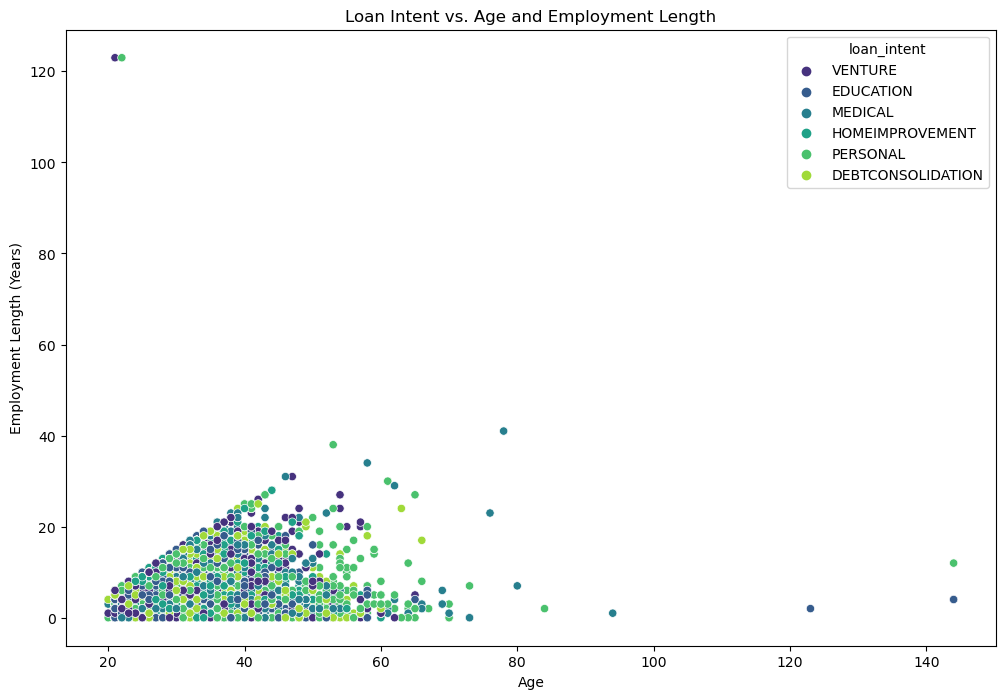

In [286]:
#| label: fig-scatter-loan
#| fig-cap: Loan Intent 

plt.figure(figsize=(12, 8))
sns.scatterplot(x='person_age', y='person_emp_length', hue='loan_intent', data=df, palette='viridis')
plt.title('Loan Intent vs. Age and Employment Length')
plt.xlabel('Age')
plt.ylabel('Employment Length (Years)')
plt.show()

Regarding @fig-scatter-loan, we can see some patterns within the dataset among loan intentions. 

Most notably in the bottom left corner of the plot, which indicates both a young age and limited employment history, there is a culmination of both Educational and Venture loans being used. 

This makes sense given the current context of the world, as young individuals would most likely be in college or other forms of education at this time. On a similar note, venture capital is often used for newly formed or aspiring companies. Hence, the youthful age and lack of employment history match.

Conversely, as age increases, loans for medical, home improvement, and debt consolidation become more likely. This evidence is runs concurrent with today's societal concerns from our more elderly population. 

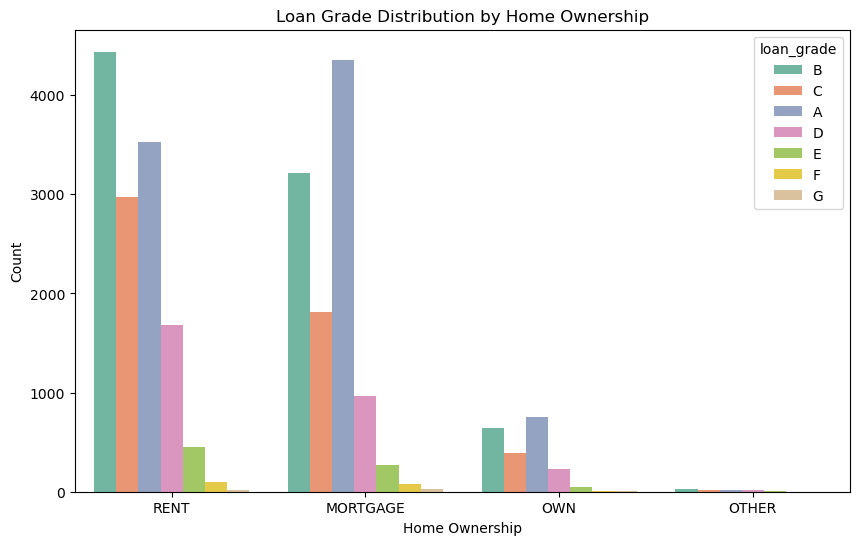

In [287]:
#| label: fig-scatter-loan-grade
#| fig-cap: Loan Grade Distribution by Home Ownership

plt.figure(figsize=(10, 6))
sns.countplot(x='person_home_ownership', hue='loan_grade', data=df, palette='Set2')
plt.title('Loan Grade Distribution by Home Ownership')
plt.xlabel('Home Ownership')
plt.ylabel('Count')
plt.show()

@fig-scatter-loan-grade illustrates the Loan grade distribution by home ownership. Loan Grade is viewed A-G with A being the highest loan grade and G being the lowest. 

An interesting observation to make here is that for individuals in both the 'Mortgage' and 'Home' groups, the highest frequency of loans is rated as an A whereas for individuals in the 'Rent' group the highest frequency of loans is rated as an B.

This could give context to the economic state of home ownership and bank trust. Those with a mortgage/own property could perhaps be linked to being more trustworthy due to having a longer term connection with a property. Banks may view those in the 'Rent' category as a bit more risky due to the short term ability of renting.

In [126]:
summary_table = df.groupby('loan_intent').agg({
    'loan_int_rate': 'mean',
    'loan_amnt': 'mean'
}).reset_index()

summary_table.rename(columns={
    'loan_int_rate': 'Average Interest Rate',
    'loan_amnt': 'Average Loan Amount'
}, inplace=True)

print(summary_table)


         loan_intent  Average Interest Rate  Average Loan Amount
0  DEBTCONSOLIDATION              10.983305          9620.901149
1          EDUCATION              10.965465          9460.015604
2    HOMEIMPROVEMENT              11.160075         10348.725017
3            MEDICAL              11.051946          9242.269907
4           PERSONAL              11.009814          9549.427178
5            VENTURE              10.940866          9516.417425


This summary table above displays the relative average interest rates and average loan amounts for each category of loan intent.

Home improvement has the greatest average loan amount while similarly having the highest interest rate. On the flip side, education has the lowest average loan amount but the second lowest interest rate.

## Part C: Build a Model

I will be utilizing a Logistic Regression Model for predicting whether a prospective borrower is likely to default on a given loan. 

I will also be utilizing the `RFECV` class from `sklearn` in order to automatically find the most useful features to use in the model. RFE is a feature selection method that fits a model and removes the weakest feature(s) until the specified number of features is reached. Using RFE, you can automate the process of finding an effective subset of features.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline


url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/train.csv"
df_all = pd.read_csv(url)

df = df_all.drop(['loan_grade', 'loan_status'], axis=1)  
df = pd.get_dummies(df, columns=['person_home_ownership', 'loan_intent', 'cb_person_default_on_file'], drop_first=True)
df.dropna(inplace=True)

y = df_all.loc[df.index, 'loan_status']  

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=123)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logreg = LogisticRegression(max_iter=1000)

selector = RFECV(estimator=logreg, step=1, cv=5)
selector = selector.fit(X_train_scaled, y_train)  # Fitting RFECV to the scaled training data


X_train_selected = selector.transform(X_train_scaled)
X_test_selected = selector.transform(X_test_scaled)

model_selected = LogisticRegression(max_iter=1000)
model_selected.fit(X_train_selected, y_train)

selected_features = X_train.columns[selector.support_]

# Prediction
y_pred_selected = model_selected.predict(X_test_selected)
print(f"Optimal number of features: {selector.n_features_}")
print(classification_report(y_test, y_pred_selected))


In [5]:
  
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=123)


In [9]:
X_train

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,cb_person_default_on_file_Y
7573,26,38000,1.0,8875,7.51,0.23,2,False,False,False,False,True,False,False,False,False
15865,25,110004,9.0,15000,7.66,0.14,4,False,False,False,False,True,False,False,False,False
18729,29,60000,3.0,7200,7.88,0.12,7,False,False,False,False,False,False,True,False,False
1288,24,44000,1.0,3200,8.00,0.07,2,False,False,True,False,False,True,False,False,False
12168,65,46000,5.0,10500,16.32,0.23,24,False,False,True,False,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17438,26,48000,10.0,15000,11.12,0.31,3,False,True,False,False,False,False,False,True,False
24566,45,118000,15.0,25000,12.18,0.21,12,False,False,False,False,True,False,False,False,False
20105,21,26000,5.0,14500,14.61,0.56,2,False,False,False,False,False,True,False,False,True
17825,35,78000,9.0,9450,10.99,0.12,8,False,False,False,False,True,False,False,False,False


In [11]:

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [12]:
X_train_scaled

array([[-0.26848589, -0.43778172, -0.91860701, ..., -0.45114679,
        -0.4630992 , -0.46344676],
       [-0.4252438 ,  0.65831624,  1.01527471, ..., -0.45114679,
        -0.4630992 , -0.46344676],
       [ 0.20178785, -0.10288151, -0.43513658, ...,  2.21657344,
        -0.4630992 , -0.46344676],
       ...,
       [-1.05227545, -0.62045457,  0.04833385, ..., -0.45114679,
        -0.4630992 ,  2.15774517],
       [ 1.14233533,  0.17112776,  1.01527471, ..., -0.45114679,
        -0.4630992 , -0.46344676],
       [ 1.61260907, -0.02676782,  0.04833385, ..., -0.45114679,
        -0.4630992 , -0.46344676]])

In [13]:

logreg = LogisticRegression(max_iter=1000)

selector = RFECV(estimator=logreg, step=1, cv=5)
selector = selector.fit(X_train_scaled, y_train)  # Fitting RFECV to the scaled training data


X_train_selected = selector.transform(X_train_scaled)
X_test_selected = selector.transform(X_test_scaled)


In [14]:
X_train_selected

array([[-0.12277222, -1.0852037 ,  0.57659278, ..., -0.49598922,
        -0.45114679, -0.4630992 ],
       [ 0.85178574, -1.03888993, -0.27169328, ..., -0.49598922,
        -0.45114679, -0.4630992 ],
       [-0.38928398, -0.97096305, -0.4602013 , ..., -0.49598922,
         2.21657344, -0.4630992 ],
       ...,
       [ 0.77222999,  1.10698175,  3.68697501, ..., -0.49598922,
        -0.45114679, -0.4630992 ],
       [-0.0312831 , -0.01072407, -0.4602013 , ..., -0.49598922,
        -0.45114679, -0.4630992 ],
       [ 0.85178574, -0.20524194,  0.57659278, ...,  2.01617286,
        -0.45114679, -0.4630992 ]])

In [16]:
from sklearn.metrics import classification_report

model_selected = LogisticRegression(max_iter=1000)
model_selected.fit(X_train_selected, y_train)

selected_features = X_train.columns[selector.support_]

# Prediction
y_pred_selected = model_selected.predict(X_test_selected)
print(f"Optimal number of features: {selector.n_features_}")
print(classification_report(y_test, y_pred_selected))


Optimal number of features: 8
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      3614
           1       0.68      0.48      0.56       968

    accuracy                           0.84      4582
   macro avg       0.77      0.71      0.73      4582
weighted avg       0.83      0.84      0.83      4582



The code below is used to identify which features will be used for the most optimal model prediction.

In [18]:
feature_names = df.columns

selected_features = feature_names[selector.support_]

print("Selected features:", selected_features)


Selected features: Index(['loan_amnt', 'loan_int_rate', 'loan_percent_income',
       'person_home_ownership_OWN', 'person_home_ownership_RENT',
       'loan_intent_EDUCATION', 'loan_intent_PERSONAL', 'loan_intent_VENTURE'],
      dtype='object')


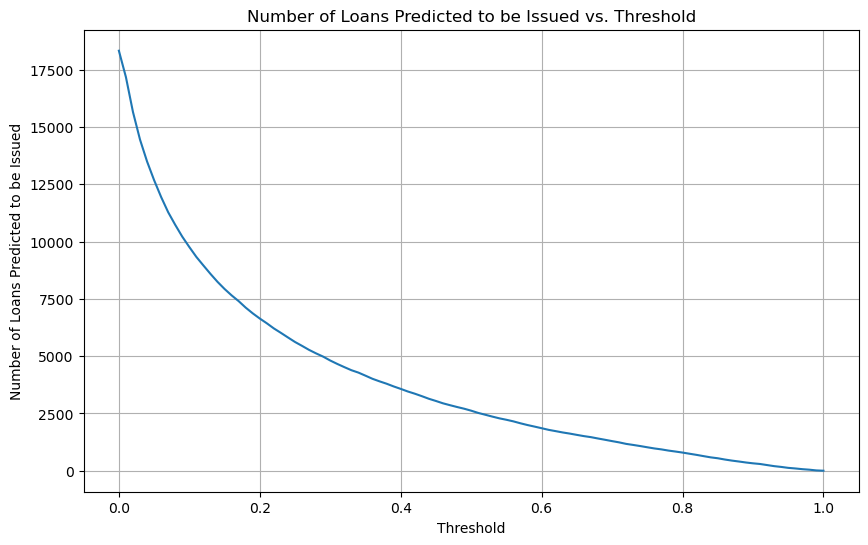

In [55]:
import numpy as np
import matplotlib.pyplot as plt

thresholds = np.linspace(0, 1, 101)
issued_counts = []

for threshold in thresholds:
    X_train['predicted_issued'] = X_train['probabilities'] >= threshold
    issued_count = X_train['predicted_issued'].sum()  
    issued_counts.append(issued_count)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, issued_counts)
plt.title('Number of Loans Predicted to be Issued vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Number of Loans Predicted to be Issued')
plt.grid(True)
plt.show()


In [56]:
X_train

,loan_amnt,loan_int_rate,loan_percent_income,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_PERSONAL,loan_intent_VENTURE,probabilities,actual,prediction_probability,predicted_issued,gain_loss
7573,8875,7.51,0.23,False,False,False,False,False,0.105087,0,0.105087,False,0
15865,15000,7.66,0.14,False,False,False,False,False,0.023507,0,0.023507,False,0
18729,7200,7.88,0.12,False,False,False,True,False,0.022012,0,0.022012,False,0
1288,3200,8.00,0.07,False,True,False,False,False,0.061475,0,0.061475,False,0
12168,10500,16.32,0.23,False,True,False,False,True,0.600637,0,0.600637,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17438,15000,11.12,0.31,True,False,False,False,True,0.047207,0,0.047207,False,0
24566,25000,12.18,0.21,False,False,False,False,False,0.097552,0,0.097552,False,0
20105,14500,14.61,0.56,False,False,False,False,False,0.978011,1,0.978011,False,0
17825,9450,10.99,0.12,False,False,False,False,False,0.083158,0,0.083158,False,0


In [60]:
# Estimating the profit here into rows 

thresholds = np.linspace(0, 1, 101)
average_gains = []

for threshold in thresholds:
    X_train['predicted_issued'] = X_train['prediction_probability'] >= threshold
    X_train['gain_loss'] = X_train.apply(calculate_gain_loss, axis=1)
    average_gain_loss_per_issued_loan = X_train.loc[X_train['predicted_issued'], 'gain_loss'].mean()
    average_gains.append(average_gain_loss_per_issued_loan)

# Plotting the average gain per issued loan across thresholds
plt.figure(figsize=(10, 6))
plt.plot(thresholds, average_gains, label='Average Gain Per Issued Loan')
plt.xlabel('Threshold')
plt.ylabel('Average Gain Per Issued Loan')
plt.title('Average Gain Per Issued Loan vs. Threshold')
plt.grid(True)
plt.legend()
plt.show()

In [34]:
X_train

,loan_amnt,loan_int_rate,loan_percent_income,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_PERSONAL,loan_intent_VENTURE,probabilities,actual,prediction_probability,predicted_issued,gain_loss
7573,8875,7.51,0.23,False,False,False,False,False,0.105087,0,0.105087,False,0
15865,15000,7.66,0.14,False,False,False,False,False,0.023507,0,0.023507,False,0
18729,7200,7.88,0.12,False,False,False,True,False,0.022012,0,0.022012,False,0
1288,3200,8.00,0.07,False,True,False,False,False,0.061475,0,0.061475,False,0
12168,10500,16.32,0.23,False,True,False,False,True,0.600637,0,0.600637,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17438,15000,11.12,0.31,True,False,False,False,True,0.047207,0,0.047207,False,0
24566,25000,12.18,0.21,False,False,False,False,False,0.097552,0,0.097552,False,0
20105,14500,14.61,0.56,False,False,False,False,False,0.978011,1,0.978011,False,0
17825,9450,10.99,0.12,False,False,False,False,False,0.083158,0,0.083158,False,0


## Cross Validation

I did not want to limit myself to only one model however, so I used `cross_val_score` from the `sklearn.model_selection` in order to compare how my 'Optimal' LR model did against other LR models with a different combination of features.

In [70]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np

selected_features = ['loan_amnt', 'loan_int_rate', 'loan_percent_income', 'person_home_ownership_OWN', 'person_home_ownership_RENT', 'loan_intent_EDUCATION', 'loan_intent_PERSONAL', 'loan_intent_VENTURE']


feature_combinations = [
    ['loan_amnt', 'loan_int_rate'],  
    ['loan_percent_income', 'person_home_ownership_RENT'],  
    selected_features  
]


In [72]:
results = {}

for features in feature_combinations:
    # Scale features
    X_scaled = scaler.fit_transform(df[features])
    
    LR = LogisticRegression(max_iter=10000)
    
    cv_scores_LR = cross_val_score(LR, X_scaled, y, cv=5)
    results[str(features)] = cv_scores_LR.mean()

for combo, score in results.items():
    print(f"Features: {combo}\nCV Score (mean accuracy): {score}\n")


Features: ['loan_amnt', 'loan_int_rate']
CV Score (mean accuracy): 0.7973108709793388

Features: ['loan_percent_income', 'person_home_ownership_RENT']
CV Score (mean accuracy): 0.8471203482091736

Features: ['loan_amnt', 'loan_int_rate', 'loan_percent_income', 'person_home_ownership_OWN', 'person_home_ownership_RENT', 'loan_intent_EDUCATION', 'loan_intent_PERSONAL', 'loan_intent_VENTURE']
CV Score (mean accuracy): 0.848342893535451



As seen above, the 'Optimal' feature LR model performed the best in predicting the likelihood of a default.

## Part D: Finding a Threshold 

In this section, we will be exploring how I came up with the threshold `t` that will be used for our model.

I used the `numpy` package to compute linear scores across all `n` of our training points.

I plotted the scores below in order to easily visualize this process. By gathering scores, we can easily simulate decision-making with a given threshold.

In [257]:
import numpy as np
import matplotlib.pyplot as plt

def linear_score(X, w):
    return X @ w


In [258]:
# Extracting weights 
w = model.coef_.flatten()  


In [259]:

scores = linear_score(X_train_selected, w) 


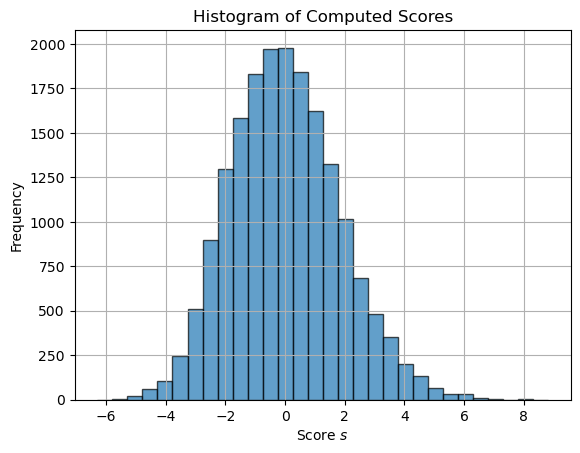

In [260]:
#| label: fig-hist-score
#| fig-cap: Histogram of Computed Scores

plt.hist(scores, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel(r"Score $s$")
plt.ylabel("Frequency")
plt.title("Histogram of Computed Scores")
plt.grid(True)
plt.show()


# ROC Curve 

Next we created an ROC curve in order to illustrate all the possible tradeoffs between the True Positive Rate and False Positive Rate that are achievable for a given score as we vary the threshold `t`

In [261]:
import numpy as np
import matplotlib.pyplot as plt

num_thresholds = 101
FPR = np.zeros(num_thresholds)
TPR = np.zeros(num_thresholds)

T = np.linspace(scores.min() - 0.1, scores.max() + 0.1, num_thresholds)

for i in range(num_thresholds):
    t = T[i]
    preds = scores >= t
    FPR[i] = ((preds == 1) & (y_train == 0)).sum() / (y_train == 0).sum()
    TPR[i] = ((preds == 1) & (y_train == 1)).sum() / (y_train == 1).sum()


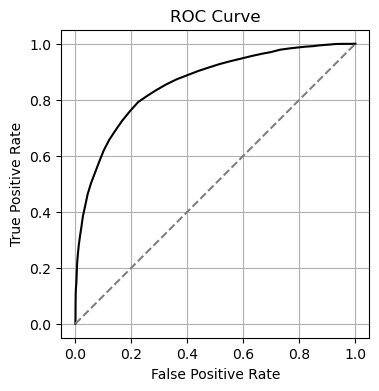

In [262]:
#| label: fig-ROC
#| fig-cap: ROC curve for Model

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.plot(FPR, TPR, color="black")
ax.plot([0, 1], [0, 1], linestyle="--", color="grey")  
ax.set_aspect('equal')

ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curve")

plt.grid(True)
plt.show()


As seen in @fig-ROC, our curve bows towards the top left of the plot. Indicating that our model is a more effective classifier. 

For a reference curves that bow towards the top left of the plot are seen as more effective classifiers and those that bow inwards are seen as less effective classifiers.

## Evaluate Different Thresholds

Although the previous data from @fig-hist-score and @fig-ROC are useful, often times banks want to set a threshold that maximizes profit-loss. 

We use a two assumptions below to account for the profit and loss of a bank if a loan is repaid in full and if a loan is defaulted on. 

We then calculate the expected profit per issued loan for each threshold, and find the threshold that is the most optimal for generating overall profit. We can accomplish this by generating a `gain_loss` column within our `X_train` dataset in order to easily summarize the overall average gain/loss for each issued loan at each threshold value.

This relationship is illustrated in @fig-thres.


In [102]:
X = df[selected_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## MODEL HERE
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

# Predict probabilities
probabilities = model.predict_proba(X_train_scaled)[:, 1]

X_train['actual'] = y_train
X_train['prediction_probability'] = probabilities



In [77]:
def calculate_gain_loss(row):
    if row['predicted_issued']:
        if row['actual'] == 0:  # Loan was repaid
            return row['loan_amnt'] * (1 + 0.25 * row['loan_int_rate'])**10 - row['loan_amnt']
        elif row['actual'] == 1:  # Loan defaulted
            return row['loan_amnt'] * (1 + 0.25 * row['loan_int_rate'])**3 - 1.7 * row['loan_amnt']
    return 0


In [78]:
# Estimating the profit here into rows 

thresholds = np.linspace(0, 1, 101)
average_gains = []

for threshold in thresholds:
    X_train['predicted_issued'] = X_train['prediction_probability'] >= threshold
    X_train['gain_loss'] = X_train.apply(calculate_gain_loss, axis=1)
    
    # Check if any loans are predicted to be issued at this threshold
    if X_train['predicted_issued'].sum() > 0:
        average_gain_loss_per_issued_loan = X_train.loc[X_train['predicted_issued'], 'gain_loss'].mean()
    else:
        # No loans are issued, so append a default value (e.g., 0) to avoid NaN
        average_gain_loss_per_issued_loan = 0
    
    average_gains.append(average_gain_loss_per_issued_loan)

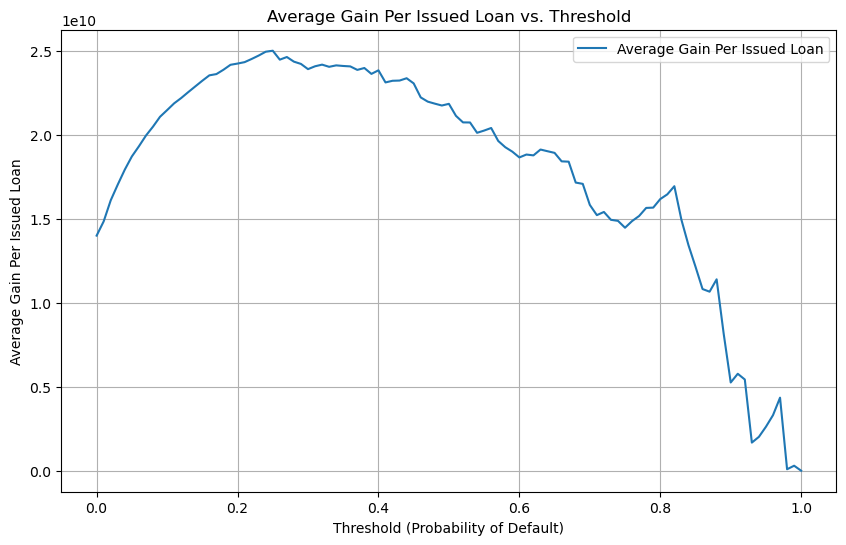

In [79]:
#| label: fig-thres
#| fig-cap: Expected Profit per Loan vs Threshold 

# Plotting the average gain per issued loan across thresholds
plt.figure(figsize=(10, 6))
plt.plot(thresholds, average_gains, label='Average Gain Per Issued Loan')
plt.xlabel('Threshold (Probability of Default)')
plt.ylabel('Average Gain Per Issued Loan')
plt.title('Average Gain Per Issued Loan vs. Threshold')
plt.grid(True)
plt.legend()
plt.show()


In [80]:
optimal_index = np.argmax(average_gains)
optimal_threshold = thresholds[optimal_index]
print(f"Optimal Threshold: {optimal_threshold}")
print(f"Average Gain Per Issued Loan at Optimal Threshold: {average_gains[optimal_index]}")

Optimal Threshold: 0.25
Maximum Average Gain Per Issued Loan at Optimal Threshold: 24992323662.99832


We use the above code to find the most optimal threshold which presents us with the highest level of expected profit. 

Our model finds that a threshold of 0.25 is the most optimal, with an expected average gain of $24,992,323,663 per borrower

While yes, this number appears rather high, our simple assumptions assume compounded interest while real life situations may differ significantly

## Part E: Evaluating the Model from the Bank's Perspective

After finding an optimal threshold value of 0.25, let's see how our model compares to the test set.

# Pre-Process the Test Dataset

First we have to prepare the test set by performing the same preprocessing steps we did on our training set.

In [91]:

# Load test data
df_test = pd.read_csv("https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/test.csv")

df_test = pd.get_dummies(df_test, columns=['person_home_ownership', 'loan_intent', 'cb_person_default_on_file'], drop_first=True)
df_test.dropna(inplace=True)



In [95]:
X_test = df_test.drop(['loan_grade', 'loan_status'], axis=1)
y_test = df_test['loan_status'].values

selected_features = ['loan_amnt', 'loan_int_rate', 'loan_percent_income', 'person_home_ownership_OWN', 'person_home_ownership_RENT', 'loan_intent_EDUCATION', 'loan_intent_PERSONAL', 'loan_intent_VENTURE']

X_test = df_test[selected_features]

In [96]:

probabilities_test = model.predict_proba(X_test)[:, 1]

/Users/donovanwood/anaconda3/envs/ml-0451/lib/python3.9/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [97]:
X_test['prediction_probability'] = probabilities_test

/var/folders/6z/mh947m1s1m17ylsnt3y4rkfc0000gn/T/ipykernel_39820/2783352999.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['prediction_probability'] = probabilities_test


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Load data
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/train.csv"
df_all = pd.read_csv(url)

# Dropping rows with missing target or essential features for the specified analysis
df = df_all.drop(['loan_grade', 'loan_status'], axis=1)  
df = pd.get_dummies(df, columns=['person_home_ownership', 'loan_intent', 'cb_person_default_on_file'], drop_first=True)
df.dropna(inplace=True)

y = df_all.loc[df.index, 'loan_status']  

# Preparing the features (including creation of dummy variables for categorical features)
selected_features = ['loan_amnt', 'loan_int_rate', 'loan_percent_income', 'person_home_ownership_OWN', 'person_home_ownership_RENT', 'loan_intent_EDUCATION', 'loan_intent_PERSONAL', 'loan_intent_VENTURE']

X = df[selected_features]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the logistic regression model
model = LogisticRegression(max_iter=10000)
model.fit(X_train_scaled, y_train)

# Predict probabilities
probabilities = model.predict_proba(X_train_scaled)[:, 1]

# Threshold for making a loan (e.g., where model predicts no default)
threshold = 0.8

# Calculate the gain, loss, and the decision to issue a loan
df_train = pd.DataFrame(X_train, columns=selected_features)
df_train['Actual'] = y_train.values
df_train['Prob_NoDefault'] = probabilities
df_train['Decision'] = df_train['Prob_NoDefault'] >= threshold

# Profit and loss calculations)
def calculate_profit(loan_amnt, loan_int_rate):
    return loan_amnt * (1 + 0.25 * loan_int_rate)**10 - loan_amnt

def calculate_loss(loan_amnt, loan_int_rate):
    return -(loan_amnt * (1 + 0.25 * loan_int_rate)**3 - 1.7 * loan_amnt)

# Apply profit/loss based on decision and actual outcome
df_train['PNL'] = 0
df_train.loc[df_train['Decision'] & (df_train['Actual'] == 1), 'PNL'] = df_train.apply(lambda row: calculate_loss(row['loan_amnt'], row['loan_int_rate']), axis=1)
df_train.loc[df_train['Decision'] & (df_train['Actual'] == 0), 'PNL'] = df_train.apply(lambda row: calculate_profit(row['loan_amnt'], row['loan_int_rate']), axis=1)

# Calculate expected profit per loan issued (only include loans where a decision to issue was made)
issued_loans = df_train[df_train['Decision']]
expected_profit_per_issued_loan = issued_loans['PNL'].sum() / issued_loans.shape[0] if issued_loans.shape[0] > 0 else 0

print(f"Expected Profit per Loan Issued: ${expected_profit_per_issued_loan:.2f}")

/var/folders/6z/mh947m1s1m17ylsnt3y4rkfc0000gn/T/ipykernel_5192/3730232185.py:58: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1257557.088       -328665.524875    -777366.47205    -1195907.645925
 -1666649.73280781  -897005.57521094 -1470617.988       -552622.2431625
 -1583145.2109375  -1288438.70596875  -644843.91125    -5210427.14953125
 -4944903.528375   -1743316.1328125   -112117.27455     -871944.43359375
 -2392321.27640625 -3025933.84114844  -124355.763       -777366.47205
  -950421.9375     -1067283.4195625  -1990154.01375    -1071986.30085937
 -1799328.272      -1222690.08760937  -617625.         -1257557.088
 -1101060.15359375  -795311.34373828 -3649806.827625   -1168516.73828125
 -1060895.44140625 -1420152.1443     -1229288.572       -505087.87109375
 -1402220.0859375  -5607432.61489687 -3503661.0052125  -2325739.32421875
 -1071665.02937813 -1186249.48298828  -981571.3949     -2921291.84570312
  -86272

Expected Profit per Loan Issued: $12939375668.25


In [14]:
issued_loans

,loan_amnt,loan_int_rate,loan_percent_income,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_PERSONAL,loan_intent_VENTURE,Actual,Prob_NoDefault,Decision,PNL
20675,12000,14.96,0.35,False,True,False,False,False,1,0.899886,True,-1.257557e+06
10365,8000,9.99,0.56,False,True,False,False,False,1,0.972322,True,-3.286655e+05
11608,14800,11.14,0.49,False,True,False,False,False,1,0.920965,True,-7.773665e+05
1543,14400,13.57,0.40,False,True,False,True,False,1,0.843414,True,-1.195908e+06
11628,14900,15.37,0.44,False,True,True,False,False,1,0.923548,True,-1.666650e+06
...,...,...,...,...,...,...,...,...,...,...,...,...
12263,4200,13.11,0.28,False,True,False,False,False,1,0.806834,True,-3.215749e+05
22090,2700,20.62,0.17,False,True,False,False,True,1,0.836183,True,-6.249857e+05
3103,4375,12.69,0.29,False,True,False,False,False,1,0.802679,True,-3.103722e+05
22459,10000,19.29,0.33,False,True,False,True,False,1,0.954498,True,-1.956915e+06


In [117]:
X_train

,loan_amnt,loan_int_rate,loan_percent_income,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_PERSONAL,loan_intent_VENTURE,Prediction
21383,5000,13.57,0.10,False,True,False,False,True,0.154000
2116,1200,13.85,0.02,True,False,False,False,True,0.011135
5631,6500,10.99,0.12,False,False,False,False,False,0.102757
20675,12000,14.96,0.35,False,True,False,False,False,0.899886
9582,9325,10.91,0.13,False,True,False,False,False,0.169294
...,...,...,...,...,...,...,...,...,...
13577,2500,8.88,0.05,False,True,False,True,False,0.043215
24532,17050,12.69,0.28,False,False,False,False,False,0.359268
6125,5000,13.11,0.18,False,True,True,False,False,0.360500
974,5600,12.53,0.11,False,False,True,False,False,0.082458


In [121]:

# Define profit and loss functions using the original formulas
def calculate_profit(loan_amnt, loan_int_rate):
    return loan_amnt * (1 + 0.25 * loan_int_rate)**10 - loan_amnt

def calculate_loss(loan_amnt, loan_int_rate):
    return loan_amnt * (1 + 0.25 * loan_int_rate)**3 - 1.7 * loan_amnt

# Adding Gain and Loss columns
X_train['Gain_if_Issued'] = calculate_profit(X_train['loan_amnt'], X_train['loan_int_rate'])
X_train['Loss_if_Defaulted'] = calculate_loss(X_train['loan_amnt'], X_train['loan_int_rate'])

X_train['actual'] = y_train


In [122]:
X_train

,loan_amnt,loan_int_rate,loan_percent_income,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_PERSONAL,loan_intent_VENTURE,Prediction,Gain_if_Issued,Loss_if_Defaulted,Issued,PNL,actual
21383,5000,13.57,0.10,False,True,False,False,True,0.154000,1.336865e+10,4.152457e+05,True,0,0
2116,1200,13.85,0.02,True,False,False,False,True,0.011135,3.758057e+09,1.045990e+05,True,0,0
5631,6500,10.99,0.12,False,False,False,False,False,0.102757,3.550823e+09,3.310383e+05,True,0,0
20675,12000,14.96,0.35,False,True,False,False,False,0.899886,6.870124e+10,1.257557e+06,True,0,1
9582,9325,10.91,0.13,False,True,False,False,False,0.169294,4.828637e+09,4.670971e+05,True,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13577,2500,8.88,0.05,False,True,False,True,False,0.043215,2.995678e+08,7.921562e+04,True,0,0
24532,17050,12.69,0.28,False,False,False,False,False,0.359268,2.727015e+10,1.209565e+06,True,0,0
6125,5000,13.11,0.18,False,True,True,False,False,0.360500,1.025345e+10,3.828272e+05,True,0,0
974,5600,12.53,0.11,False,False,True,False,False,0.082458,8.134228e+09,3.856888e+05,True,0,0


In [125]:

# Calculate PNL for each threshold and find the optimal threshold
thresholds = np.linspace(0, 1, 101)
optimal_profit_per_issued_loan = -np.inf
optimal_threshold = 0

for t in thresholds:
    X_train['Issued'] = X_train['Prediction'] >= t
    X_train['PNL'] = 0
    X_train.loc[X_train['Issued'] & (X_train['actual'] == 1), 'PNL'] = X_train['Gain_if_Issued']
    X_train.loc[X_train['Issued'] & (X_train['actual'] == 0), 'PNL'] = X_train['Loss_if_Defaulted']
    
   # Calculate the total PNL for loans that were issued, and then find the average PNL per issued loan
    total_pnl_for_issued_loans = X_train.loc[X_train['Issued'], 'PNL'].sum()
    num_issued_loans = X_train['Issued'].sum()

    average_pnl_per_issued_loan = total_pnl_for_issued_loans / num_issued_loans if num_issued_loans > 0 else 0

    # Check for the optimal threshold
    if average_pnl_per_issued_loan > optimal_profit_per_issued_loan:
        optimal_profit_per_issued_loan = average_pnl_per_issued_loan
        optimal_threshold = t

# Display optimal threshold and expected profit
print(f"Optimal Threshold: {optimal_threshold}")
print(f"Expected Profit per Issued Loan at Optimal Threshold: ${optimal_profit_per_loan:.2f}")


/var/folders/6z/mh947m1s1m17ylsnt3y4rkfc0000gn/T/ipykernel_39820/2274478290.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[6.87012418e+10 1.07229095e+09 2.19111733e+09 ... 1.21803553e+10
 1.32891450e+08 5.40246950e+10]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[X_train['Issued'] & (X_train['actual'] == 1), 'PNL'] = X_train['Gain_if_Issued']
/var/folders/6z/mh947m1s1m17ylsnt3y4rkfc0000gn/T/ipykernel_39820/2274478290.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[6.87012418e+10 1.07229095e+09 2.19111733e+09 ... 4.47811211e+11
 1.21803553e+10 5.40246950e+10]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[X_train['Issued'] & (X_train['actual'] == 1), 'PNL'] = X_train['Gain_if_Issued']
/var/folders/6z/mh947m1s1m17ylsnt3y4rkfc

Optimal Threshold: 0.98
Expected Profit per Issued Loan at Optimal Threshold: $-inf


/var/folders/6z/mh947m1s1m17ylsnt3y4rkfc0000gn/T/ipykernel_39820/2274478290.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[6.87012418e+10 2.19111733e+09 1.86360759e+10 ... 6.99747313e+09
 4.47811211e+11 1.21803553e+10]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[X_train['Issued'] & (X_train['actual'] == 1), 'PNL'] = X_train['Gain_if_Issued']
/var/folders/6z/mh947m1s1m17ylsnt3y4rkfc0000gn/T/ipykernel_39820/2274478290.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[6.87012418e+10 2.19111733e+09 8.93140605e+09 ... 6.99747313e+09
 4.47811211e+11 1.21803553e+10]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[X_train['Issued'] & (X_train['actual'] == 1), 'PNL'] = X_train['Gain_if_Issued']
/var/folders/6z/mh947m1s1m17ylsnt3y4rkfc